# Import and Database Connection

In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib as mpl

np.random.seed(40)

%matplotlib inline

conn = psycopg2.connect(host="47.111.23.160", dbname="research", user="nicegeek", password="iloveting1314")
cur = conn.cursor()

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [347]:
cur.close()
conn.close()

In [6]:
# 建立一个SCHEMA用于存放当前实验的所有数据
cur.execute("""
    CREATE SCHEMA thesis1;
    """)
conn.commit()

# thesis1 中各个表格存放的内容

## 存放高斯随机场的表格thesis1.raster_grf,共有100个高斯随机场

In [24]:
cur.execute("""SELECT * FROM thesis1.raster_grf
ORDER BY rid ASC LIMIT 5""")
rows = cur.fetchall()
raster = pd.DataFrame(rows, columns=[x.name for x in cur.description])
print("thesis1.raster_grf:存放高斯随机场")
raster.head(5)

thesis1.raster_grf:存放高斯随机场


,rid,rast
0,1,0100000100000000000000F03F000000000000F0BF0000...
1,2,0100000100000000000000F03F000000000000F0BF0000...
2,3,0100000100000000000000F03F000000000000F0BF0000...
3,4,0100000100000000000000F03F000000000000F0BF0000...
4,5,0100000100000000000000F03F000000000000F0BF0000...


## 存放发送点坐标的表格thesis1.transimission,共400个点随机均匀分布于0.5-499.5，-499.5--0.5区域内

In [39]:
tran_x = 0.5 + np.random.rand(400)*(499.5-0.5)
tran_y = -499.5 + np.random.rand(400)*(-0.5+499.5)

In [42]:
cur.execute("""
DROP TABLE IF EXISTS thesis1.transmission;
CREATE TABLE thesis1.transmission (
    id serial PRIMARY KEY,
    x_cord float,
    y_cord float,
    pt geometry(POINT,2334) UNIQUE
    );""")
conn.commit()

In [43]:
for x, y in zip(tran_x, tran_y):
    cur.execute("""
    INSERT INTO thesis1.transmission (x_cord, y_cord, pt)
    VALUES (%(x_cord)s, %(y_cord)s,ST_SetSRID(ST_Point(%(x_cord)s,%(y_cord)s), 2334))
    """, 
                {'x_cord':x, 'y_cord':y})
conn.commit()

In [44]:
cur.execute("""
    SELECT id,x_cord,y_cord,ST_AsText(pt) FROM thesis1.transmission
    ORDER BY id ASC LIMIT 6
    """)
rows = cur.fetchall()
transmission = pd.DataFrame(rows, columns=[x.name for x in cur.description])
print("thesis1.transmission:存放发送点的坐标")
transmission.head(5)

thesis1.transmission:存放发送点的坐标


,id,x_cord,y_cord,st_astext
0,1,489.661318,-65.382375,POINT(489.661317946865 -65.3823754562014)
1,2,180.572624,-191.092761,POINT(180.572624223696 -191.092761212161)
2,3,446.265477,-391.958452,POINT(446.265477059154 -391.958451611989)
3,4,311.821778,-379.078784,POINT(311.821777812627 -379.078784106667)
4,5,154.178055,-102.455673,POINT(154.178055149386 -102.455673274021)


## 存放空间“所有点”，在500×500范围内，每间隔1米取一个点，共250000个点，thesis1.all_points

In [45]:
# 新建一个用于存放所有点的表格thesis1.all_points
cur.execute("""
DROP TABLE IF EXISTS thesis1.all_points;
CREATE TABLE thesis1.all_points (
    id serial PRIMARY KEY,
    x_cord float,
    y_cord float,
    pt geometry(POINT,2334) UNIQUE
    );""")
conn.commit()

In [46]:
x = np.arange(0.5, 500, 1)
y = np.arange(-499.5, 0, 1)

In [47]:
cord_x, cord_y = np.meshgrid(x, y)

In [48]:
for x, y in zip(cord_x.flat, cord_y.flat):
    cur.execute("""
    INSERT INTO thesis1.all_points (x_cord, y_cord, pt)
    VALUES (%(x_cord)s, %(y_cord)s,ST_SetSRID(ST_Point(%(x_cord)s,%(y_cord)s), 2334))
    """, 
                {'x_cord':x, 'y_cord':y})
conn.commit()

In [49]:
cur.execute("""
    SELECT id,x_cord,y_cord,ST_AsText(pt) FROM thesis1.all_points
    ORDER BY id ASC LIMIT 6
    """)
rows = cur.fetchall()
all_points = pd.DataFrame(rows, columns=[x.name for x in cur.description])
print("thesis1.all_points:存放所有点的坐标共500×500，250000个")
all_points.head(5)

thesis1.all_points:存放所有点的坐标共500×500，250000个


,id,x_cord,y_cord,st_astext
0,1,0.5,-499.5,POINT(0.5 -499.5)
1,2,1.5,-499.5,POINT(1.5 -499.5)
2,3,2.5,-499.5,POINT(2.5 -499.5)
3,4,3.5,-499.5,POINT(3.5 -499.5)
4,5,4.5,-499.5,POINT(4.5 -499.5)


## 将所有点 与 发送点的连线切割成线段，计算在高斯场上线积分

- 在thesis1.all_points中取一个点，将其与发射点连线切割成线段
- 线段上每个点找到在thesis1.raster_grf上的取值，并对所有取值求和（线积分）

In [53]:
cur.execute("""
    DROP TABLE IF EXISTS thesis1.all_channel_lines_shadow;
    CREATE TABLE thesis1.all_channel_lines_shadow (
        id serial PRIMARY KEY,
        random_field_ID int,
        recv_ID int,
        trans_ID int,
        tran_recv_distance float,
        shadow_loss float,
        FOREIGN KEY (random_field_ID) REFERENCES thesis1.raster_grf(rid),
        FOREIGN KEY (recv_ID) REFERENCES thesis1.all_points(id),
        FOREIGN KEY (trans_ID) REFERENCES thesis1.transmission(id)
    );
    """)
conn.commit()

In [ ]:
for tran_point_id in range(6, 101):  
    for recv_point_id in range(1,250001):
        cur.execute("""
            INSERT INTO thesis1.all_channel_lines_shadow(random_field_ID, recv_ID, trans_ID, tran_recv_distance,shadow_loss)
             SELECT    grf.rid,               
                       trail.recv_id,
                       trail.trans_id,
                       trail.distance,
                       sum(ST_Value(rast,gd))*0.1/sqrt(trail.distance)    
             FROM 
                (SELECT 
                       trans.id as trans_id,
                       recv.id as recv_id,
                       ST_Length(ST_MakeLine(trans.pt,recv.pt)) as distance,
                       (ST_DumpPoints(ST_Segmentize(ST_MakeLine(trans.pt,recv.pt), 0.1))).geom as gd
                    FROM thesis1.transmission as trans
                    CROSS JOIN thesis1.all_points as recv WHERE trans.id=%(tran_point_id)s AND recv.id=%(recv_point_id)s) as trail
                LEFT JOIN
                 (SELECT
                         rid,
                         rast
                     FROM thesis1.raster_grf WHERE rid=1) AS grf
                ON ST_Intersects(rast, trail.gd)
                GROUP BY trail.recv_id, trail.trans_id, grf.rid, trail.distance;
            """,{'tran_point_id':tran_point_id, 'recv_point_id':recv_point_id}) 
        conn.commit()

In [2]:
for recv_point_id in range(1,250001):
    cur.execute("""
        INSERT INTO thesis1.all_channel_lines_shadow(random_field_ID, recv_ID, trans_ID, tran_recv_distance,shadow_loss)
         SELECT    grf.rid,               
                   trail.recv_id,
                   trail.trans_id,
                   trail.distance,
                   sum(ST_Value(rast,gd))*0.1/sqrt(trail.distance)    
         FROM 
            (SELECT 
                   trans.id as trans_id,
                   recv.id as recv_id,
                   ST_Length(ST_MakeLine(trans.pt,recv.pt)) as distance,
                   (ST_DumpPoints(ST_Segmentize(ST_MakeLine(trans.pt,recv.pt), 0.1))).geom as gd
                FROM thesis1.transmission as trans
                CROSS JOIN thesis1.all_points as recv WHERE trans.id=3 AND recv.id=%(recv_point_id)s) as trail
            LEFT JOIN
             (SELECT
                     rid,
                     rast
                 FROM thesis1.raster_grf WHERE rid=1) AS grf
            ON ST_Intersects(rast, trail.gd)
            GROUP BY trail.recv_id, trail.trans_id, grf.rid, trail.distance;
        """,{'recv_point_id':recv_point_id}) 
    conn.commit()

In [102]:
cur.execute("""
    SELECT id,recv_ID, recv_x, recv_y, ST_AsText(recv_point), trans_ID, ST_AsText(lines_seg) FROM thesis1.all_channel_lines_seg
    ORDER BY id ASC LIMIT 6
    """)
rows = cur.fetchall()
all_points_seg = pd.DataFrame(rows, columns=[x.name for x in cur.description])
print("thesis1.all_channel_lines_seg:存放所有点与发射点连线")
all_points_seg.head(5)

thesis1.all_channel_lines_seg:存放所有点与发射点连线


,id,recv_id,recv_x,recv_y,st_astext,trans_id,st_astext
0,1,1,0.5,-499.5,POINT(0.5 -499.5),1,"LINESTRING(0.5 -499.5,0.654745989304813 -499.3..."
1,2,2,1.5,-499.5,POINT(1.5 -499.5),1,"LINESTRING(1.5 -499.5,1.65449061662198 -499.37..."
2,3,3,2.5,-499.5,POINT(2.5 -499.5),1,"LINESTRING(2.5 -499.5,2.65413028878442 -499.37..."
3,4,4,3.5,-499.5,POINT(3.5 -499.5),1,"LINESTRING(3.5 -499.5,3.65387205387205 -499.37..."
4,5,5,4.5,-499.5,POINT(4.5 -499.5),1,"LINESTRING(4.5 -499.5,4.65361242403781 -499.37..."


## 对所有的连线在rid=1 的高斯随机场上做线积分，作为阴影衰落的值

In [ ]:
cur.execute("""
   SELECT x_cord, y_cord, trans_id, tran_recv_distance, shadow_loss
FROM thesis1.all_channel_lines_shadow
INNER JOIN thesis1.all_points
ON recv_id=thesis1.all_points.id
WHERE trans_id=2""")

# 系统模型

Saving figure SystemModel_Regular


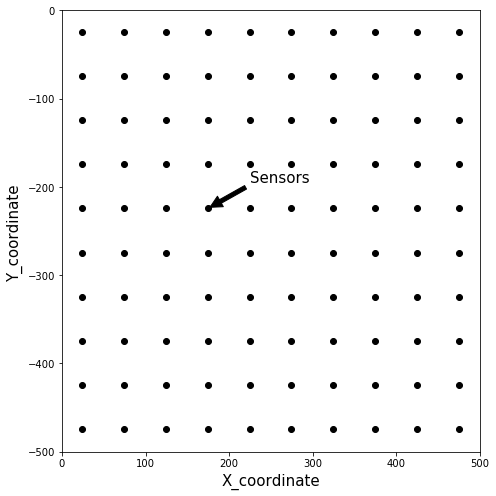

In [333]:
x_ = np.arange(24.5, 500, 50)
y_ = np.arange(-474.5, 0, 50)
x, y = np.meshgrid(x_, y_)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.scatter(x=x, y=y, c='Black')
ax.set_xlabel("X_coordinate",fontsize=15)
ax.set_ylabel("Y_coordinate", fontsize=15)
ax.set(xlim=[0,500], ylim=[-500, 0])
ax.annotate('Sensors',xy=(x[5,3],y[5,3]),xytext=(x[5,3]+50,y[5,3]+30),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=15)
save_fig("SystemModel_Regular")

Saving figure SystemModel_Random


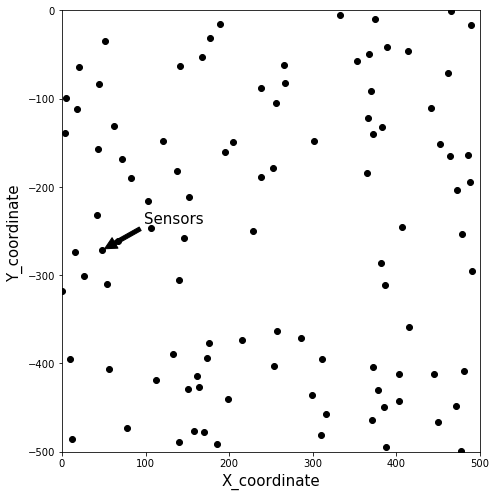

In [337]:
x_ = np.arange(0.5, 500, 1)
y_ = np.arange(-499.5, 0, 1)
np.random.seed(40)
x = np.random.choice(x_, 100, replace=False)
y = np.random.choice(y_, 100, replace=False)
i = 19
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.scatter(x=x, y=y, c='Black')
ax.set_xlabel("X_coordinate",fontsize=15)
ax.set_ylabel("Y_coordinate", fontsize=15)
ax.set(xlim=[0,500], ylim=[-500, 0])
ax.annotate('Sensors',xy=(x[i],y[i]),xytext=(x[i]+50,y[i]+30),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=15)
save_fig("SystemModel_Random")

# 仿真实验
## 1.数据生成
1.在空间生成一个高斯随机场

2.在范围内任取一点作为信号发射源

3.利用空间传播损耗模型，计算500×500个点位置的接收信号强度：利用高斯随机场模拟阴影衰落

4.以上数据存入数据库，作为仿真对比分析的依据

In [66]:
cur.execute("""
   SELECT x_cord, y_cord, trans_id, tran_recv_distance, shadow_loss
FROM thesis1.all_channel_lines_shadow
INNER JOIN thesis1.all_points
ON recv_id=thesis1.all_points.id
WHERE trans_id=2""")
rows = cur.fetchall()
data = pd.DataFrame(rows, columns=[x.name for x in cur.description])
print("thesis1.all_points:存放所有点的坐标共500×500，250000个")
data.head(5)

thesis1.all_points:存放所有点的坐标共500×500，250000个


,x_cord,y_cord,trans_id,tran_recv_distance,shadow_loss
0,0.5,-499.5,2,357.129073,-3.114427
1,1.5,-499.5,2,356.625896,-10.734577
2,2.5,-499.5,2,356.124816,1.260687
3,3.5,-499.5,2,355.625842,6.770112
4,4.5,-499.5,2,355.128982,13.270984


In [67]:
trans_x=180.57
trans_y=-191.09

In [73]:
data=data.sort_values(by=['y_cord','x_cord'], ascending=[False,True])

In [207]:
data

,x_cord,y_cord,trans_id,tran_recv_distance,shadow_loss,recv_power
249500,0.5,-0.5,2,262.205550,-1.200783,-35.853248
249501,1.5,-0.5,2,261.519799,-9.261509,-43.874169
249502,2.5,-0.5,2,260.836079,-3.371125,-37.943993
249503,3.5,-0.5,2,260.154406,-2.190771,-36.723862
249504,4.5,-0.5,2,259.474796,-3.594765,-38.088096
...,...,...,...,...,...,...
495,495.5,-499.5,2,440.788245,1.710437,-40.837613
496,496.5,-499.5,2,441.503264,9.643132,-32.929555
497,497.5,-499.5,2,442.219387,7.564989,-35.032333
498,498.5,-499.5,2,442.936611,14.752173,-27.869782


In [208]:
η = 3.5
trans_power = 50

In [209]:
data['recv_power']=trans_power - 10 * η * np.log10(data['tran_recv_distance']) + data['shadow_loss']

In [247]:
data_asarray = data.values

In [245]:
def area_plot(ax, x_cord, y_cord, power):
    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=-70, vmax=70)
    out = ax.scatter(x=x_cord, y=y_cord, c=power, cmap=cmap, norm=norm)
    return out

AttributeError: 'AxesSubplot' object has no attribute 'get_array'

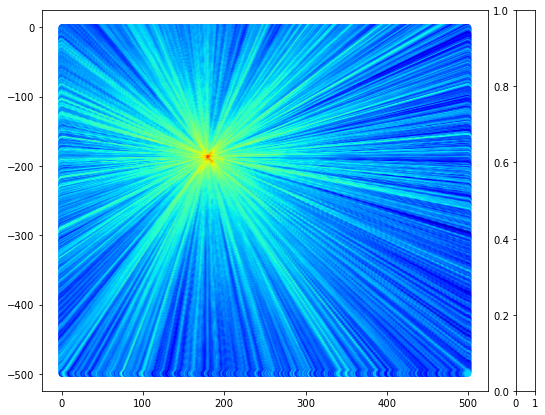

In [339]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=-70, vmax=70)
ax.scatter(x=data_asarray[:,0], y=data_asarray[:,1], c=data_asarray[:,-1], cmap=cmap, norm=norm)
cb = plt.colorbar(ax)
cb.set_label("Receive Signal Power")
plt.xlabel("X_coordinate")
plt.ylabel("Y_coordinate")

## 空间100个监测点的接收数据

In [192]:
x = np.arange(24.5, 500, 50)
y = np.arange(-474.5, 0, 50)

In [193]:
sensor_data = data[data.x_cord.isin(x) & data.y_cord.isin(y)]

sensor_data

,x_cord,y_cord,trans_id,tran_recv_distance,shadow_loss,recv_power
237524,24.5,-24.5,2,228.280118,-5.440545,-37.986928
237574,74.5,-24.5,2,197.495695,-4.223878,-34.568395
237624,124.5,-24.5,2,175.776242,-0.255036,-28.828642
237674,174.5,-24.5,2,166.703404,-7.110235,-34.878291
237724,224.5,-24.5,2,172.286861,-5.518230,-33.787056
...,...,...,...,...,...,...
12774,274.5,-474.5,2,298.566600,-12.674983,-49.301426
12824,324.5,-474.5,2,317.859643,-1.935127,-39.513365
12874,374.5,-474.5,2,343.405722,-0.484939,-39.238202
12924,424.5,-474.5,2,373.925431,-4.497279,-44.544754


In [262]:

me_error = np.sqrt(3) * np.random.randn(100) # 假设存在3dbm的测量误差
sensor_data['recv_power_me_error']=sensor_data['recv_power'] + noise
sensor_data_asarray = sensor_data.values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Y_coordinate')

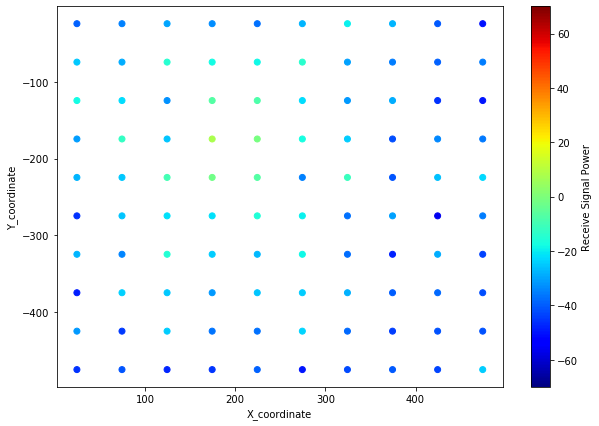

In [267]:
plt.figure(figsize=(10, 7))
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=-70, vmax=70)
plt.scatter(x=sensor_data_asarray[:,0], y=sensor_data_asarray[:,1], c=sensor_data_asarray[:,-1], cmap=cmap, norm=norm)
cb = plt.colorbar()
cb.set_label("Receive Signal Power")
plt.xlabel("X_coordinate")
plt.ylabel("Y_coordinate")

In [296]:
# points to interpolation
x = np.arange(24.5, 500, 50)
y = np.arange(-474.5, 0, 50)
interpolation_points_data = data[~(data.x_cord.isin(x) & data.y_cord.isin(y))]

In [312]:
interpolation_points_data

,x_cord,y_cord,trans_id,tran_recv_distance,shadow_loss,recv_power
249500,0.5,-0.5,2,262.205550,-1.200783,-35.853248
249501,1.5,-0.5,2,261.519799,-9.261509,-43.874169
249502,2.5,-0.5,2,260.836079,-3.371125,-37.943993
249503,3.5,-0.5,2,260.154406,-2.190771,-36.723862
249504,4.5,-0.5,2,259.474796,-3.594765,-38.088096
...,...,...,...,...,...,...
495,495.5,-499.5,2,440.788245,1.710437,-40.837613
496,496.5,-499.5,2,441.503264,9.643132,-32.929555
497,497.5,-499.5,2,442.219387,7.564989,-35.032333
498,498.5,-499.5,2,442.936611,14.752173,-27.869782


## 方法一：逆距离加权法

In [227]:
a = plt.get_cmap('jet',1000)
print(a(-60))

(0.0, 0.0, 0.5, 1.0)


## 方法：MCMC

1.用一个已知的数据，推算参数的后验分布

2.用参数的后验分布做插值

In [313]:
import pystan
%load_ext jupyterstan

## stan model

In [ ]:
%%stan spectrum_nn
functions {
  matrix cov_matern(vector[] x, real sigma, real fai, int upsilon) {
    int N=size(x);
    real dist;
    matrix[N, N] cov; 
    for (j in 1:N) 
      for (i in j:N) {
        dist = distance(x[i], x[j]);
        if (dist==0)
            cov[i,j] = 1;
        else 
           cov[i, j] = ((sigma ^ 2) / (2^(upsilon - 1) * tgamma(upsilon)))
          *((fai * dist) ^ upsilon) * modified_bessel_second_kind(upsilon, fai * dist);
      cov[j, i] = cov[i, j];
      }
    return cov;
  }
}

data {
  int<lower=1> N; //感知节点个数
  int<lower=1> D; //数据组数
  real tran_power[D]; //信号源发送功率
  real tran_x[D]; //信号源坐标
  real tran_y[D];
  vector[N] recv_x;// 每组数据有N个感知节点
  vector[N] recv_y;
  vector[N] Y[D];
 
}

transformed data {
  matrix[N, N] distance_between_recv;
  for (i in 1:N){
    for (j in 1:N){
      distance_between_recv[i][j] = sqrt2((recv_x[i]-recv_x[j])^2 + (recv_y[i]-recv_y[j])^2);
    }
  }
}

parameters {
  real sigma_eta; // 空间方差
  real fai;  // matern 协方差函数
}
transformed parameters {

}

model {
  vector[N] dist_tran_recv;
  matrix[N,N] Sigma;
  vector[N] i_vec = rep_vector(1.0, N);
  matrix[N, N] unit_matrix = diag_matrix(i_vec);
  int upsilon = 2; 
  
  /********************/
  /*    指定先验分布    */
  /********************/
  sigma_eta ~ inv_gamma(2, 10);
  fai ~ uniform(1, 100);
  
  
  Sigma = cov_matern(recv_coord, sigma_eta, fai, upsilon);
  Y ~ multi_normal(tran_power - 10 * gamma * log10(dist_tran_recv), Sigma);  
}

In [ ]:
mcmc_data = {'N':100,
             'D':1,
             'tran_power':       //num of data is D
             'tran_x':
             'tran_y':
             'recv_x':list(data['rec_coord'].map(trans_x)),
             'recv_y':list(data['rec_coord'].map(trans_y)),
             'Y':list(data.iloc[:, 3]),
             }